## Classify RCAs into groups

### Summary
Classify RCAs into groups using geographic, habitat and human use variables (e.g., area of the RCAs) using k-means clustering.

### Methods
* Load previously calculated variables, transform and standardize as needed.
* Look for correlations between variables using plots and variance inflation factor and remove variables that are highly correlated with other variables.
* Calculate the principle components (PCA) from the set of variables and examine the amount of variation they explain.
* Select the optimal number of clusters (k) qualitatively by plotting mean inertia (elbow plot) and silhouette coefficient by number of clusters. 
* Create k clusters from the principle components using the kmeans clustering algorithm (https://scikit-learn.org/stable/modules/clustering.html).
* Calculate the squared distance in principle component space between each RCA and its cluster centroid as a measure of fit. 

### Figures
* RCA clusters are visualized in both principle component (PC1 and PC2) and geographic (x and y) space.
* The distribution and mean value of the variables across RCAs are plotted by cluster.

### Bathymetry data density
* The 'BathyQuality' variable represents the density of bathymetry points within RCAs ranging from low (0) to high (1). A score of one indicates that their is multibeam coverage for the entire RCA. 
* Bathy quality is plotted for all RCAs and the RCAs with the lowest quality of bathymetry data are identified.

In [1]:
# Import necessary modules
import numpy as np # for numpy array 
from matplotlib import pyplot as plt # for base plots
import matplotlib as mpl # for colour map customization
import seaborn as sns # for strip plots
from pathlib import Path # for handling file paths
import pandas as pd # for dataframe
import geopandas as gp # for spatial dataframes
from sklearn.decomposition import PCA # for PCA
from sklearn.cluster import KMeans # for kmeans algorithm
from sklearn.metrics import silhouette_score # for number of clusters selection
from sklearn import preprocessing # for scaling data
from statsmodels.stats.outliers_influence import variance_inflation_factor # for VIF

In [2]:
# Read in data from csv
geo = pd.read_csv("Geographic/georgraphic_variables.csv") 
hab = pd.read_csv("Habitat/habitat_variables.csv", index_col=0) 
use = pd.read_csv("HumanUse/human_variables.csv", index_col=0) 

# Convert region to numbers
geo['Region'] = geo['Region'].replace({'Inside' : 0, 'Outside' : 1})

# Combine
data = pd.concat([hab, use.drop(['Name'], axis=1), geo.drop(['Name', 'FID'], axis=1)], axis=1)

# Preview
print(data.columns)
data

Index(['Name', 'Depth', 'Slope', 'Complexity', 'Rock', 'Exposure', 'Tidal',
       'BathyQuality', 'Kelp', 'Eelgrass', 'SpongeReef', 'Population',
       'Near_Base', 'Coast_Infr', 'Trawl_Fish', 'Traps_Fish', 'Area', 'X', 'Y',
       'Region', 'CenterEdgeDist', 'EdgeArea', 'NearestRCA'],
      dtype='object')


Name       Depth      Slope  Complexity  \
0               Ajax / Achilles Bank  120.432988   2.579934    0.880112   
1                    Ballenas Island  382.061662  15.188045    0.887081   
2            Bate - Shadwell Passage   77.644469   3.681859    0.830494   
3          Baynes Sound - Ship Point   32.881484   3.727701    0.793154   
4                    Becher Bay East   47.498712   7.319720    0.860126   
..                               ...         ...        ...         ...   
157  West Cracroft Island - Boat Bay  229.078166  15.073741    0.892138   
158                West of Bajo Reef   41.148980   0.657202    0.871028   
159                   West Vancouver  165.600623  11.791869    0.800500   
160                  Weynton Passage  134.396134   9.437112    0.859791   
161                 Woolridge Island  213.278770  19.761995    0.361046   

         Rock  Exposure     Tidal  BathyQuality      Kelp  Eelgrass  ...  \
0    0.051005  0.074503  0.059112      0.996476  0.000000  0.000000  ...   
1    0.211847  0.077727  0.065573      0.924338  0.000000  0.000000  ...   
2    0.429945  0.072302  0.188952      0.406688  0.249120  0.000000  ...   
3    0.138425  0.010698  0.043647      0.906780  0.000000  0.000000  ...   
4    0.728917  0.036646  0.144316      0.572028  0.401065  0.000000  ...   
..        ...       ...       ...           ...       ...       ...  ...   
157  0.889554  0.015049  0.449897      0.600725  0.086302  0.000000  ...   
158  0.223020  0.433199  0.131985      0.019610  0.000000  0.000000  ...   
159  0.270116  0.037158  0.050946      0.924605  0.000000  0.000267  ...   
160  0.852956  0.016330  0.410791      0.289868  0.075939  0.000000  ...   
161  0.383428  0.006871  0.020265      0.827511  0.000000  0.000000  ...   

     Coast_Infr  Trawl_Fish  Traps_Fish       Area             X            Y  \
0      0.000000  181.434103  293.782654  73.906678  1.101101e+06  511929.6163   
1      0.000000    0.000000  717.154307   5.804190  1.135096e+06  481972.6125   
2      0.013986    0.000000    0.337600  17.772524  8.735326e+05  657287.2433   
3      0.000000    0.000000  481.717767   2.528451  1.087420e+06  499929.8620   
4      0.000000    0.000000   13.061260   1.008070  1.178226e+06  370227.7640   
..          ...         ...         ...        ...           ...          ...   
157    0.000000    0.000000    3.710599   3.638227  9.616338e+05  611604.5351   
158    0.069930    0.000000   35.000958  41.784571  9.331906e+05  510545.8600   
159    0.000000    0.000000    0.000000   2.819528  1.196825e+06  486218.6268   
160    0.000000    0.000000    0.530488  17.593870  9.411933e+05  619543.6216   
161    0.055944    0.000000  132.915081   3.793149  1.184474e+06  503095.7558   

     Region  CenterEdgeDist  EdgeArea  NearestRCA  
0         0            1.82      0.67         4.3  
1         0            1.15      1.60         2.4  
2         0            1.53      0.50         3.2  
3         0            0.48      2.84         4.5  
4         0            0.39      3.18         4.7  
..      ...             ...       ...         ...  
157       0            0.65      1.41         4.9  
158       1            2.13      0.75        23.2  
159       0            0.56      1.92         0.4  
160       0            1.57      1.08         7.6  
161       0            0.87      1.61         3.6  

[162 rows x 23 columns]

Name  BathyQuality             X             Y
52                 Frederick Island      0.010987  5.296753e+05  1.008863e+06
20        Burley Bay - Nepah Lagoon      0.011406  9.443420e+05  6.614873e+05
51                  Forward Harbour      0.011579  1.019097e+06  6.076231e+05
43   Drury Inlet - Muirhead Islands      0.012603  9.206258e+05  6.566556e+05
33                       Dare Point      0.012753  1.087495e+06  4.044667e+05
152                       Wellborne      0.012927  1.010794e+06  6.072093e+05
80                Mackenzie - Nimmo      0.012949  9.501309e+05  6.582507e+05
102                   Pachena Point      0.016002  1.070981e+06  4.102642e+05
22                         Carmanah      0.016129  1.093990e+06  3.988849e+05
158               West of Bajo Reef      0.019610  9.331906e+05  5.105459e+05
90                Mid Finlayson Arm      0.072138  1.181946e+06  3.939393e+05
6                     Bedwell Sound      0.076118  1.013496e+06  4.752482e+05
8                   Belleisle Sound      0.084209  9.697332e+05  6.525038e+05
94                    Nelson Island      0.084433  1.131284e+06  5.250534e+05
74                       Kwatsi Bay      0.089311  9.818719e+05  6.490953e+05
11                       Bond Sound      0.092263  9.864306e+05  6.480620e+05
136                        Susquash      0.094575  9.122771e+05  6.263159e+05
58                   Greenway Sound      0.097097  9.469796e+05  6.475158e+05

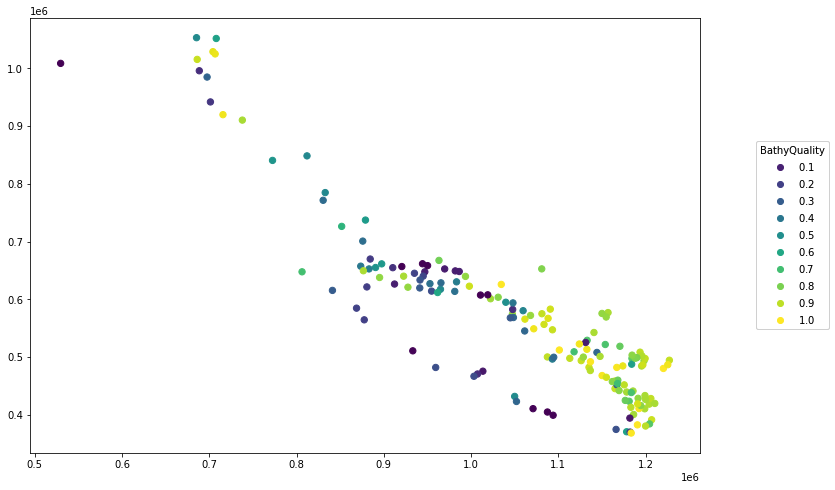

In [3]:
# Which RCAs have the lowest density of bathymetry data

# Subset data 
lowden = data.loc[data.BathyQuality < 0.1, ['Name','BathyQuality','X','Y']]

# Map the clusters
fig, ax = plt.subplots()
scatter = ax.scatter(data['X'], data['Y'], c=data['BathyQuality'], s=40)

# Produce a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(),  bbox_to_anchor=(1.2, 0.5), 
                   loc='center right', title='BathyQuality')

# Put a legend to the right of the current axis
ax.add_artist(legend)
fig.set_size_inches(12, 8)
fig.show()

# Show RCAs with low density of bathymetry points
lowden.sort_values(by=['BathyQuality'])

NearestRCA    8.0
EdgeArea      5.4
Depth         3.0
Rock          7.0
Exposure      4.9
Kelp          3.2
Population    2.3
Near_Base     2.9
Coast_Infr    1.5
Traps_Fish    4.8
dtype: float64


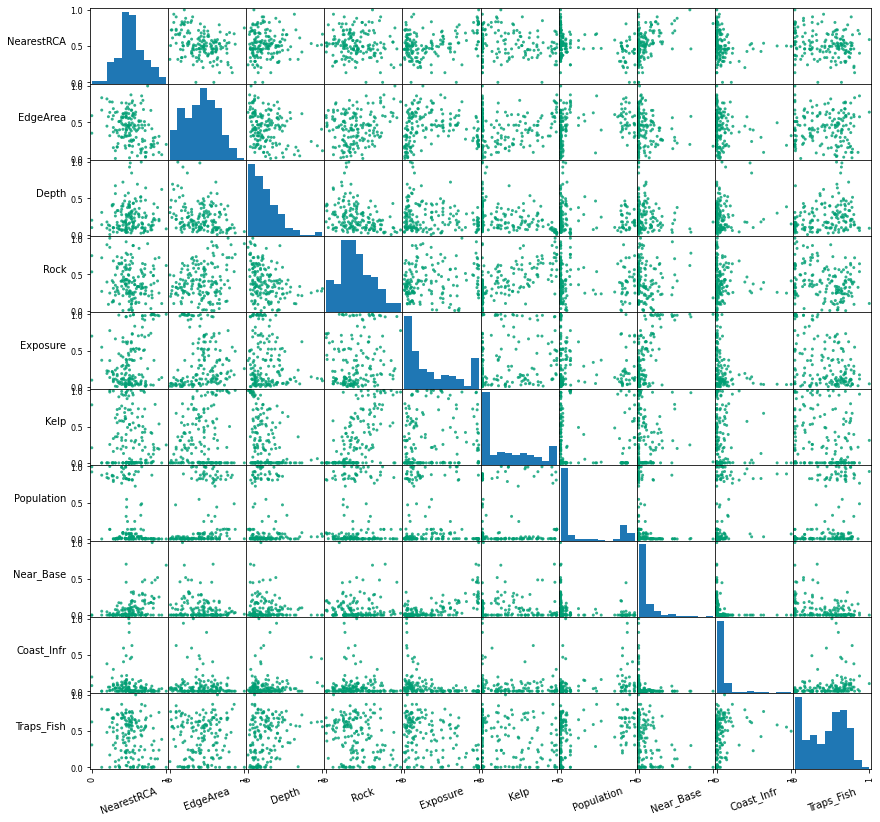

In [4]:
# Variables used for clusters
# Variables removed because of high VIF: 
# Area, CenterEdgeDistance, Slope, Complexity 
# Variables removed because of skewed distribution: (high values in very few RCAs, zero value in majority of RCAs)
# SpongeReef, Eelgrass and trawl fishing
# Tidal current removed because of data quality issues (differences between Salish Sea and QCS)
# Including region in clustering just pulls out all outside region RCAs into their own cluster
allvars  = ['Area', 'NearestRCA', 'EdgeArea', 'Region',
            'Depth', 'Slope', 'Complexity', 'Rock', 'Exposure', 'Tidal', 'BathyQuality', 'Kelp', 'Eelgrass', 'SpongeReef',
            'Population', 'Near_Base', 'Coast_Infr', 'Trawl_Fish', 'Traps_Fish']

clustervars = ['NearestRCA', 'EdgeArea', 'Depth', 'Rock', 'Exposure', 'Kelp',
            'Population', 'Near_Base', 'Coast_Infr', 'Traps_Fish']

# Subset of data, only variables (no RCA names or PIDs)
data_allvars = data[allvars].copy()

# Variable transformations
to_trans = ['NearestRCA','EdgeArea','Exposure', 'Kelp', 'Traps_Fish' ]
# Transform to make the probability distribution of a variable more Gaussian
# Stabilizing the variance of the distribution
power = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)
data_trans = power.fit_transform(data_allvars[to_trans])
# Replace columns in num_vars with transformed variables
data_allvars[to_trans] = data_trans

# Normalize numerical variables
# Range between 0 and 1 so each variable has equal weighting in clustering
scaler = preprocessing.MinMaxScaler()
var_scaled = scaler.fit_transform(data_allvars)

# Convert to pandas df and included only selected variables 'clustervars'
scaled_df = pd.DataFrame(var_scaled)
scaled_df.columns = data_allvars.columns

# Subset, variables to use for clustering
cluster_df = scaled_df[clustervars]

# VIF
print( round(pd.Series([variance_inflation_factor(cluster_df.values, i) 
                 for i in range(cluster_df.shape[1])], index=cluster_df.columns),1) ) 

# Plot corelation matrix
# Look for colinearity
axes = pd.plotting.scatter_matrix(cluster_df, alpha = 0.8, figsize = (14,14), color="#009E73");
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(20)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.show()

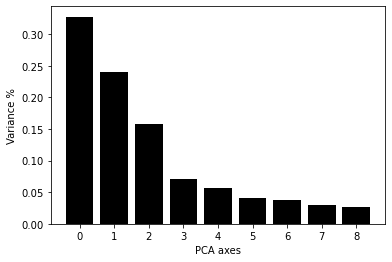

In [5]:
# Get principal components to visualize clusters 
num = cluster_df.shape[1]-1
pca = PCA(n_components=num)
pc = pca.fit_transform(cluster_df)
data['PCA1'] = pc[:,0]
data['PCA2'] = pc[:,1]

# Plot the explained variances for the pcas
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA axes')
plt.ylabel('Variance %')
plt.xticks(features)
plt.show()

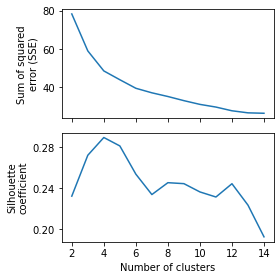

In [6]:
# Choosing the appropriate number of clusters
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
silhouette_coefficients = [] 
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pc)
    sse.append(kmeans.inertia_)
    score = silhouette_score(pc, kmeans.labels_) #The best value is 1 and the worst value is -1. 
    silhouette_coefficients.append(score)
    
# Plot SSE v number of clusters
fig=plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(range(2, 15), sse, color='tab:blue')
plt.xticks(range(2,15,2))
plt.ylabel("Sum of squared\nerror (SSE)")
plt.tick_params('x', labelbottom=False)

# plot silhouette scores v number of clusters
ax2 = fig.add_subplot(2,1,2)
ax2.plot(range(2, 15), silhouette_coefficients, color='tab:blue')
plt.xticks(range(2,15,2))
plt.yticks([0.2,0.24,0.28])
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette\ncoefficient")

# Show and export
plt.tight_layout()
plt.show()
fig.savefig("Figures/Number_clusters.png", dpi=300,  facecolor='white', bbox_inches='tight')

In [7]:
# Create clusters based on k selected from SSE and Silhouette
# Max number of clusters is 10 for colour palette in plots
k=4
clusters = KMeans(n_clusters=k,     
                  init="random", 
                  n_init=10,
                  max_iter=300,
                  random_state=42)
clusters.fit(pc)

# The lowest sum of squared errors (SSE) value
# Average distance between centroid and points
print('SSE = ', round(clusters.inertia_, 2))

# The number of iterations required to converge
print('Iterations = ', clusters.n_iter_)

# evaluation step - which clusters are better than others

# Add cluster labels to dataframe
data['Cluster'] = clusters.labels_
scaled_df['Cluster'] = clusters.labels_

# Get centroids and group lables
centroids = clusters.cluster_centers_

# Calculate the squared distance between each point and its cluster centroid
distances = clusters.transform(pc)
dist = np.empty(shape=(distances.shape[0]))
i = 0
for label in clusters.labels_:
    dist[i] = distances[i][label]
    i = i + 1
data['SquaredDistance'] = dist ** 2
inertia = data.groupby(['Cluster'])['SquaredDistance'].sum()

# Write all RCAs with variables to csv
data.to_csv('All/all_RCAs_clusters.csv', index=True)  
scaled_df.to_csv('All/all_RCAs_clusters_scaled.csv', index=True)  
np.save('All/centroids.npy', centroids)

SSE =  48.61
Iterations =  9


In [8]:
# Set consistent cluster colours all subsequent for plots
cbPalette = ["#CC79A7", "#E69F00", "#56B4E9", "#009E73"]
my_cmap = mpl.colors.ListedColormap(cbPalette)
sns.set_palette(sns.color_palette(cbPalette))

Cluster
0     8.638420
1    17.145304
2    15.487626
3     7.339775
Name: SquaredDistance, dtype: float64


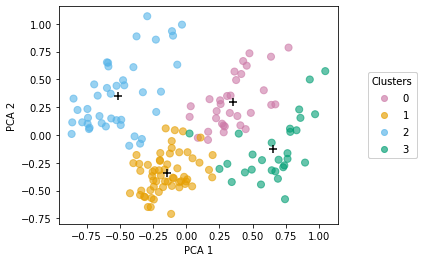

In [9]:
# Plot clusters with PCA 1 and 2 axes
fig, ax = plt.subplots()
scatter = ax.scatter(data['PCA1'], data['PCA2'], c=data['Cluster'], s=50, cmap=my_cmap, alpha=0.6)
ax.scatter(centroids[:,0],centroids[:,1], s=60, color="black", marker="+")
# produce a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(),  bbox_to_anchor=(1.3, 0.5), 
                   loc="center right", title="Clusters")
# Put a legend to the right of the current axis
ax.add_artist(legend)
fig.set_size_inches(5, 4)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
fig.show()
plt.savefig("Figures/Clusters_PCAaxes.png", dpi=300,  facecolor='white', bbox_inches='tight')

# Show SSE by cluster
print( inertia )

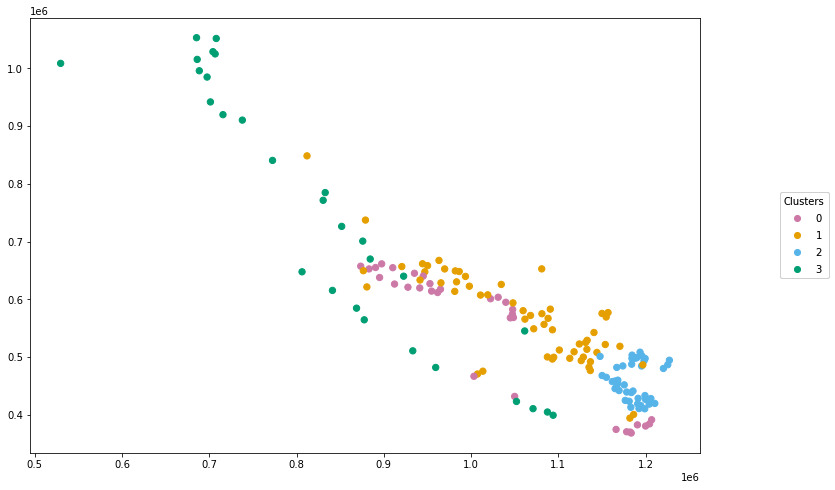

In [10]:
# Map the clusters
fig, ax = plt.subplots()
scatter = ax.scatter(data['X'], data['Y'], c=data['Cluster'], s=40, cmap=my_cmap)

# produce a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(),  bbox_to_anchor=(1.2, 0.5), 
                   loc="center right", title="Clusters")

# Put a legend to the right of the current axis
ax.add_artist(legend)
fig.set_size_inches(12, 8)
fig.show()

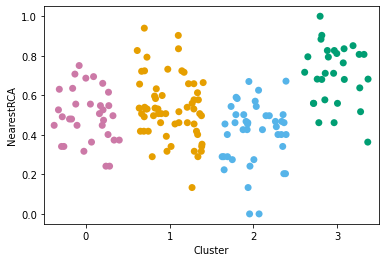

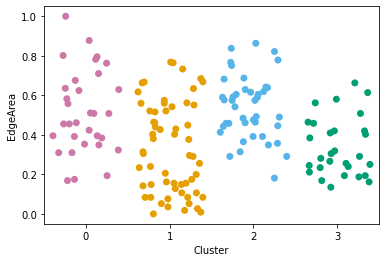

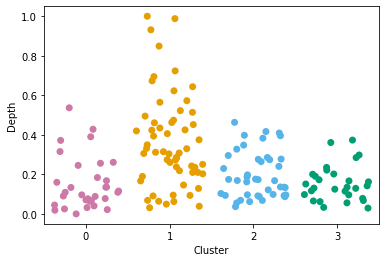

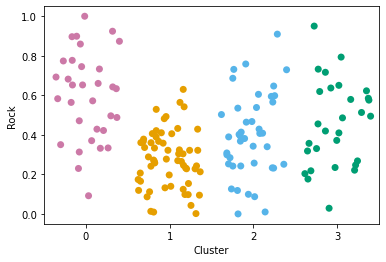

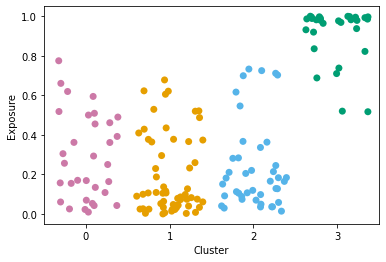

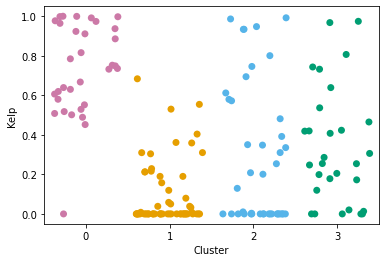

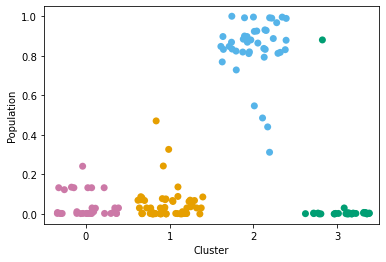

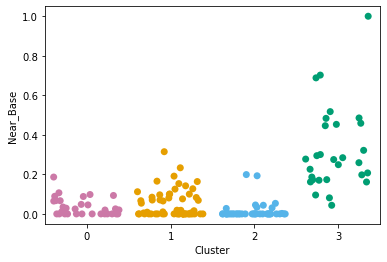

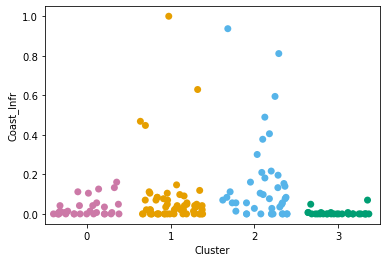

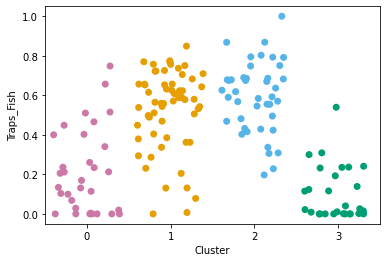

In [11]:
# Distribution of RCAs across variables by cluster
# Just the variables(scaled) used for clustering
for i in clustervars:
    plt.figure()
    sns.stripplot(x='Cluster', y=i, data=scaled_df, jitter=0.4, s=7)

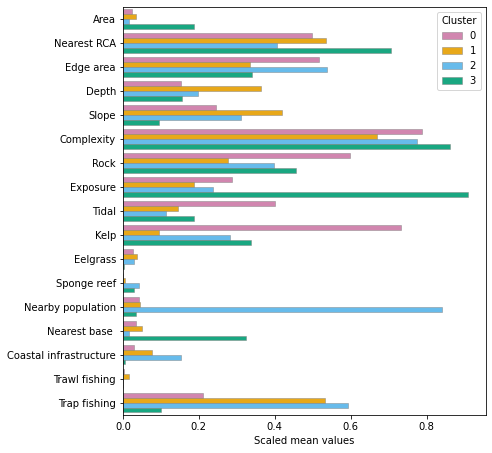

In [27]:
# Calculate mean values of variables for each cluster

# For original variables
cluster_means = data.drop(['PCA1', 'PCA2', 'SquaredDistance'], axis=1).groupby('Cluster').agg(['mean']).round(2).transpose().droplevel(level=1).reset_index()
cluster_means.rename(columns={'index':'Variable'}, inplace=True)
cluster_means.to_csv('All/cluster_means.csv', index=True)  

# For scaled variables (0 to 1)
cluster_means_scaled = scaled_df.groupby('Cluster').agg(['mean']).round(3).transpose().droplevel(level=1).reset_index()
cluster_means_scaled.rename(columns={'index':'Variable'}, inplace=True)
cluster_means_scaled.to_csv('All/cluster_means_scaled.csv', index=True)  

# Scaled mean value for each variable by cluster
cluster_means_scaled = cluster_means_scaled.drop(cluster_means_scaled[
    cluster_means_scaled['Variable'] == 'BathyQuality'].index)
cluster_means_scaled = cluster_means_scaled.drop(cluster_means_scaled[
    cluster_means_scaled['Variable'] == 'Region'].index)
cluster_m = cluster_means_scaled.melt(
    id_vars=['Variable'], value_vars=list(cluster_means_scaled.columns[1:]))

# rename variables
cluster_m['Variable'] = cluster_m['Variable'].replace(['NearestRCA'],'Nearest RCA')
cluster_m['Variable'] = cluster_m['Variable'].replace(['EdgeArea'],'Edge area')
cluster_m['Variable'] = cluster_m['Variable'].replace(['SpongeReef'],'Sponge reef')
cluster_m['Variable'] = cluster_m['Variable'].replace(['Near_Base'],'Nearest base ')
cluster_m['Variable'] = cluster_m['Variable'].replace(['Coast_Infr'],'Coastal infrastructure')
cluster_m['Variable'] = cluster_m['Variable'].replace(['Traps_Fish'],'Trap fishing')
cluster_m['Variable'] = cluster_m['Variable'].replace(['Trawl_Fish'],'Trawl fishing')
cluster_m['Variable'] = cluster_m['Variable'].replace(['Population'],'Nearby population')

# plot
plt.figure(figsize=(6.5, 7.5))
ax=sns.barplot(y='Variable', x='value', hue="Cluster", data=cluster_m,
               saturation=1, edgecolor='grey', alpha = 0.9, linewidth=0.5)
ax.set(ylabel='', xlabel='Scaled mean values')
fig.show()
plt.savefig("Figures/MeanVariable_Cluster.png", dpi=300,  facecolor='white', bbox_inches='tight')

In [13]:
# Export RCA polygon with variables as attributes

# Load RCA polys (including prawn and crab variables already)
rcas_poly_file = "/mnt/d/Projects/RCA-monitoring/Data/RCA2019/RCA_2019_prawn_crab.shp"

rca_polys = gp.read_file(rcas_poly_file)

# Remove redundant columns
rca_polys = rca_polys.drop(['NAME','SUM_HECTAR', 'SUM_SQ_KM', 'SUM_Shape_', 'SUM_Shape1', 'SUM_Shap_1', 'POLY_AREA',
                            'PERIMETER', 'CENTROID_X', 'CENTROID_Y', 'Raster_Val'], axis=1)

# Add variables
rca_polys[data.columns] = data

# Reorder names
rca_polys = rca_polys[['Name','geometry','Region','SubRegion', 'Cluster', 'PrevSample', 
                       'Area','X','Y','CenterEdgeDist','EdgeArea','NearestRCA',
                       'Depth','Slope','Complexity','Rock','Exposure','Tidal',
                       'BathyQuality','Kelp','Eelgrass','SpongeReef','Population',
                       'Near_Base','Coast_Infr','Trawl_Fish','Traps_Fish','Crab_trap',
                       'Prawn_trap', 'PCA1', 'PCA2', 'SquaredDistance']]

# Write to file
rcas_polys_variables = "/mnt/d/Projects/RCA-monitoring/Classification/All/Shapefiles/All_RCAs_Variables.shp"
rca_polys.to_file(rcas_polys_variables)